In [1]:
!wget https://www.dropbox.com/s/9kjr0ui9qbodfao/dog-breed-identification.zip # download files from Dropbox as zip

import os
import zipfile

local_zip = 'dog-breed-identification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('Dog Vision') # unzip the files into a file called "Dog Vision"
zip_ref.close()

--2023-11-05 09:14:03--  https://www.dropbox.com/s/9kjr0ui9qbodfao/dog-breed-identification.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9kjr0ui9qbodfao/dog-breed-identification.zip [following]
--2023-11-05 09:14:03--  https://www.dropbox.com/s/raw/9kjr0ui9qbodfao/dog-breed-identification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd0756fa156063b7a48f987b40e.dl.dropboxusercontent.com/cd/0/inline/CG8HYjJvb-YRACYhvA3k1dKJQwV-jQkMy4zJY5u6zGDZBkDcMEWrQSRELzy1RtHhNIa2wwvUxUWTPhEwvwkA0mmU7fyfqykSyWraubnNUVnInLN4Likv3aEjE49RvfHLrGFBXeSN2Aluggx65ZBje_l_/file# [following]
--2023-11-05 09:14:04--  https://ucd0756fa156063b7a48f987b40e.dl.dropboxusercontent.com/cd/0/inline/CG8HYjJvb-YRACYhvA3k1dKJQwV-jQkMy4zJY5u6zGDZBkDcMEWrQS

# End to end multi-class dog breed classification

Uses tensorflow and tensorflow hub

## 1. Problem
Identifying breed of a dog given an image of a dog

## 2. Data
The data is from : https://www.kaggle.com/competitions/dog-breed-identification/data?select=test

## 3. Evaluation
Evaluation is a file with prediction probabilities for each dog breed of each test image

## 4. Features
* Dealing with images (unstructured data) -> use deep learning/transfer learning
* 120 breeds of dogs (multiclass classification)


# Get our workspace ready
* import Tensorflow
* import TensorFlow Hub
* Use a GPU

In [2]:
# Import tensorflow into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF Version:", tf.__version__)
print("TF Hub Version:", hub.__version__)

# Check for GPU availibility
print("GPU", "Available" if tf.config.list_physical_devices("GPU") else "not available")

TF Version: 2.14.0
TF Hub Version: 0.15.0
GPU Available


## Turning data into tensors

In [3]:
# checkout labels of data
import pandas as pd
labels_csv = pd.read_csv("/content/Dog Vision/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: >

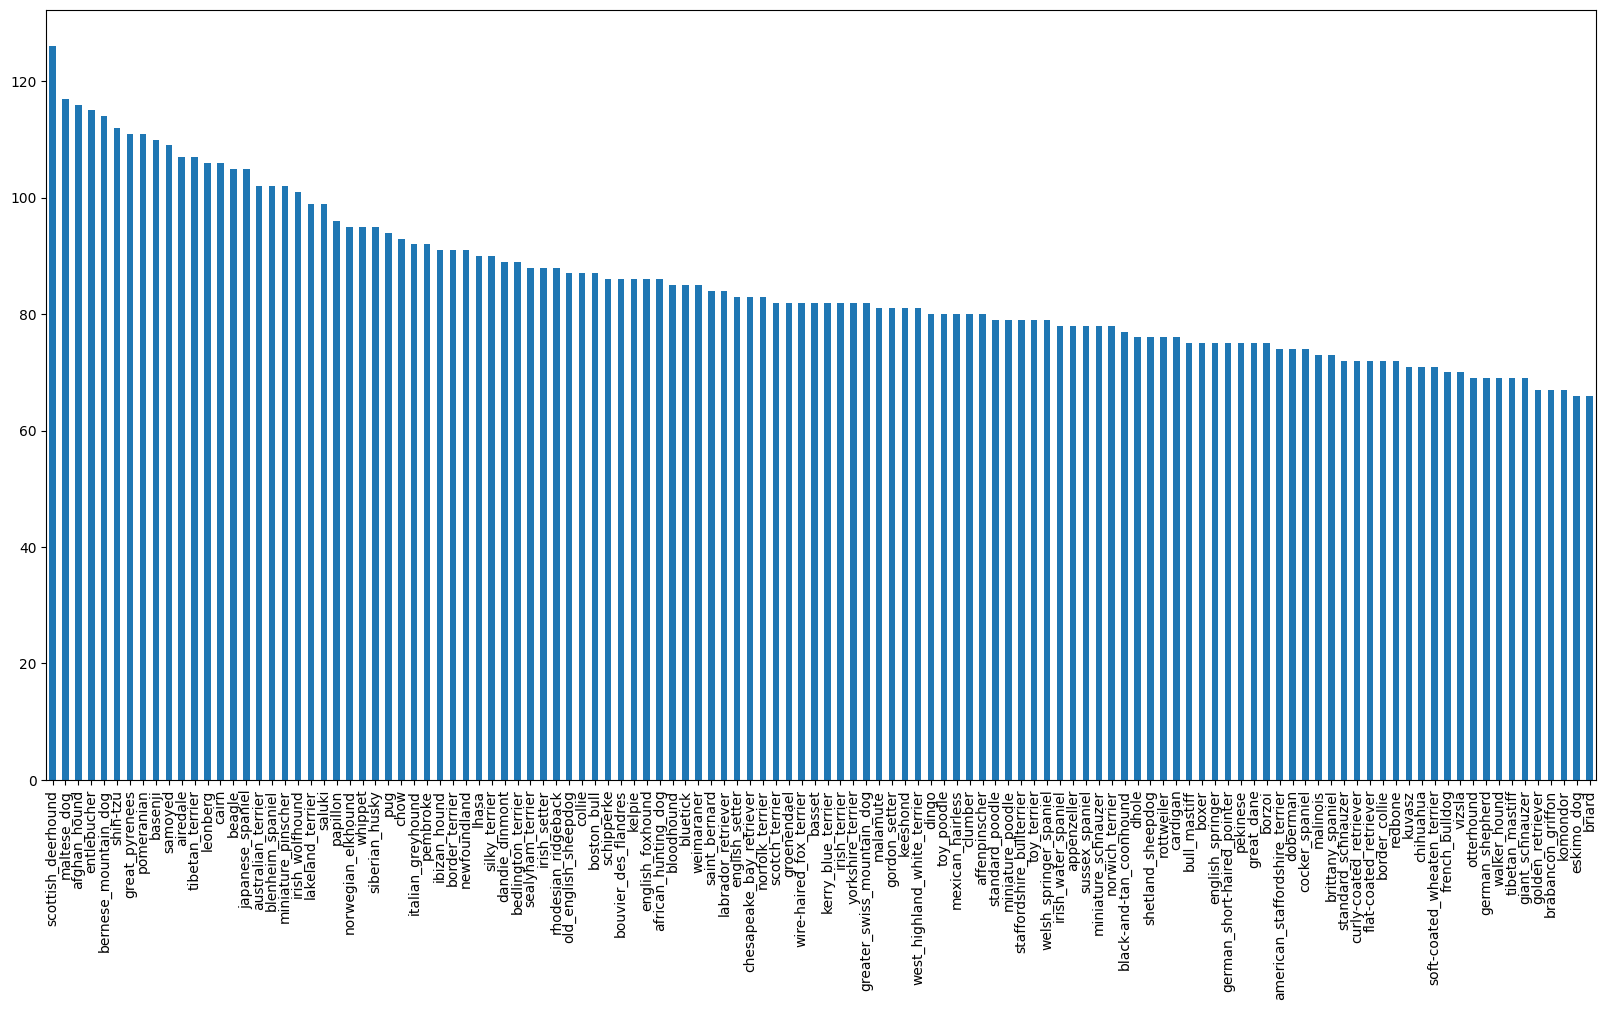

In [5]:
# how many images of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [6]:
labels_csv["breed"].value_counts().median()

82.0

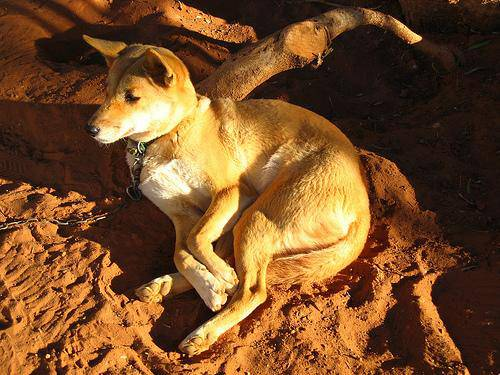

In [7]:
# View an image
from IPython.display import Image
Image("/content/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

# Getting images and their labels


In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
# create pathnames from ID's
filenames = ["/content/Dog Vision/train/"+fname+".jpg" for fname in labels_csv["id"]]
filenames[:10]

['/content/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# check if no. of filenames matches number of actual image files
import os
if len(os.listdir("/content/Dog Vision/train/")) == len(filenames):
  print("filenames match the actual length of files")
else:
  print("dont match")

filenames match the actual length of files


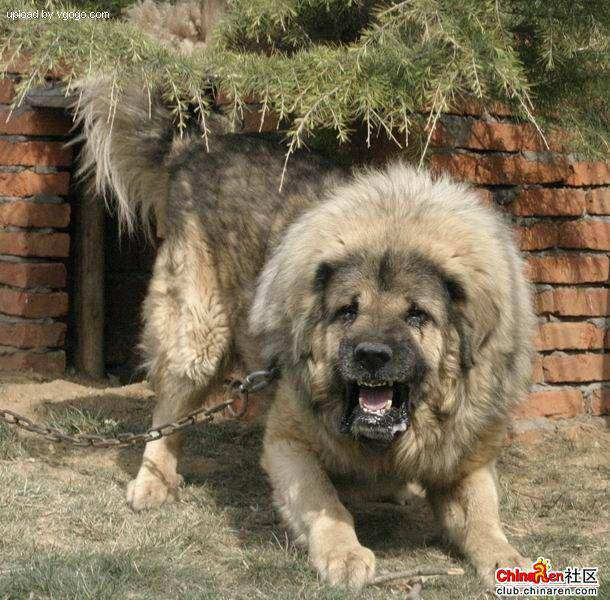

In [11]:
# one more check
Image(filenames[9000])

In [12]:
labels_csv["breed"][9000]

'tibetan_mastiff'

# Prepare our labels

In [13]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels)
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# check if no.of labels matches no of filenames
if len(labels) == len(filenames):
  print("matches")
else:
  print("does not match")

matches


In [16]:
# find unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [17]:
# turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
# turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [19]:
len(boolean_labels)

10222

In [20]:
# turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where abel occurs in boolean array
print(boolean_labels[0].astype(int)) # there is a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# creating the validation set

In [21]:
# setup X and y
X = filenames
y = boolean_labels

In [22]:
len(filenames)

10222

Start of experimenting with 1000 images

CONVENTION : hyperparameters are in uppercase

In [23]:
# set no. of images to use for experimenting
NUM_IMAGES = 1000 # @param {type:"slider", min:1000, max:10000, step:1}
NUM_IMAGES

1000

In [24]:
# split data into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [25]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['/content/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fa

# preprocessing images - turning images into tensors

function:
1. take an image filepath as input
2. use tensorflow to read the file and save it to a variable `image`
3. turn `image` (a jpg) into tensors
4. normalize our image by converting color channel values from 0-255 to 0-1
5. resize the `image`to be a shape of (224, 224)
6. return the modified `image`

In [26]:
# convert an image to a Numpy Array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [27]:
image.max(), image.min() # rgb values

(255, 0)

In [28]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [29]:
tf.constant(image)[:2] # turn into tensor

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [30]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

# Turning our data into batches

Batch - a small portion of images (32) so that it fits into memory

Data needs to be in form of tensor tuples: `(image, label)`

In [31]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

# Turning all of our data into tuples of tensors in the form: `(image, label)`

In [32]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [33]:
# create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [34]:
# check out different attributes of data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

# Visualizing data batches



In [35]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

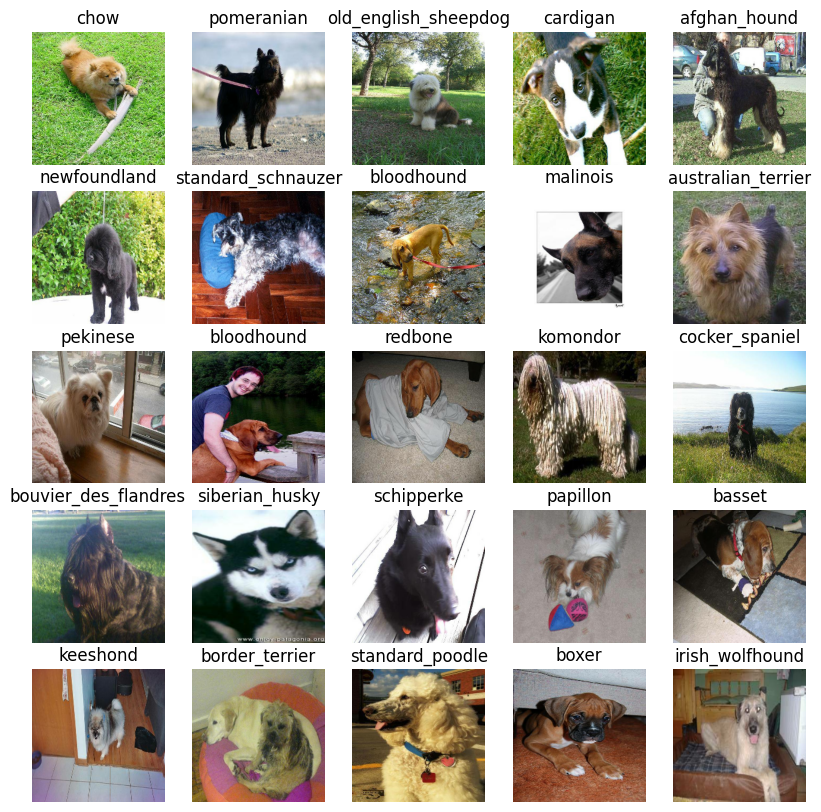

In [36]:
# turns the data into an iterator and the next helps us take the top 25
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [37]:
len(train_images), len(train_data)

(32, 25)

# Building a model using transfer learning

* Input shape
* Output shape
* URL of the model - https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4

In [38]:
# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels
# setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)
# setup model URL from tensorflow hub
MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

# putting inputs, outputs and model into a keras deep learning model

* takes input shape, output shape and model as parameters
* defines layers in a keras model in sequential fashion
* compiles the model - evaluate and improve
* builds the model - tells model the input shape it will be getting
* returns the model

steps can be found : https://www.tensorflow.org/guide/keras

In [39]:
# crete a function that builds a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Byuilding a model with:", MODEL_URL)

  # Setup model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),  #Layer 1-> input layer
      tf.keras.layers.Dense(units=OUTPUT_SHAPE, # 120
                                  activation="softmax") # layer 2 -> output layer
  ])

  # compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # how well the model is guessing
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # build the model
  model.build(INPUT_SHAPE)

  return model

In [40]:
model = create_model()
model.summary()

Byuilding a model with: https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 3660505 (13.96 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


# creating callbacks:
* save its progress
* check its progress - TensorBoard - loss goes down and accuracy goes up
* stop training early

## TensorBoard Calback
1. load notebook extension
2. create a callback that saves logs to a directory and passes it to the model's `fit()` function
3. visualize models training logs with the %tensorboard magic function


In [41]:
# load TensorBoard notebook extension
%load_ext tensorboard

In [42]:
import datetime

# create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # create a log direcotory for storing logs
  logdir = os.path.join("/content/Dog Vision/logs",
                        # make it so our logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%d%m%Y-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

# early stopping callback
 prevents overfitting
 stops training if a certain evaluation metric stops improving

In [43]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

# training a model (on a subset of data)

first model only trains on 1000 images

In [44]:
NUM_EPOCHS = 100 # @param {type:"slider", min:10, max:100, step:10}
# 100 epochs = model gets 100 chances to go through dataset and find patterns

In [45]:
# check to make sure we are still running gpu
print("GPU", "available"
      if tf.config.list_physical_devices("GPU")
      else "not available")

GPU available


# function that trains a model

* create a model using `create_model()`
* setup a TensorBoard callback using `create_tensorboard_callback()`
* call the `fit()` function on model by passing it:
  - training data
  - validation data
  - no of epochs to train for
  - callbacks
* return model

In [46]:
# build a function to train and return a trined model
def train_model():
  '''
  trains a given model and returns trained version
  '''

  # create a model
  model = create_model()

  # create a TensorBoard seesion everytime we train a model
  tensorboard = create_tensorboard_callback()

  # fit the model
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])

  return model

In [47]:
# fir the model to data
model = train_model()

Byuilding a model with: https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4
Epoch 1/100
25/25 [==============================] - 14s 102ms/step - loss: 4.5708 - accuracy: 0.1075 - val_loss: 3.2221 - val_accuracy: 0.3200
Epoch 2/100
25/25 [==============================] - 2s 79ms/step - loss: 1.5521 - accuracy: 0.6875 - val_loss: 1.9686 - val_accuracy: 0.5600
Epoch 3/100
25/25 [==============================] - 2s 83ms/step - loss: 0.5219 - accuracy: 0.9388 - val_loss: 1.5119 - val_accuracy: 0.6850
Epoch 4/100
25/25 [==============================] - 3s 104ms/step - loss: 0.2268 - accuracy: 0.9937 - val_loss: 1.3596 - val_accuracy: 0.6850
Epoch 5/100
25/25 [==============================] - 2s 68ms/step - loss: 0.1294 - accuracy: 1.0000 - val_loss: 1.2913 - val_accuracy: 0.6900
Epoch 6/100
25/25 [==============================] - 2s 67ms/step - loss: 0.0895 - accuracy: 1.0000 - val_loss: 1.2652 - val_accuracy: 0.6850
Epoch 7/100
25/25 [==============================] - 2

# Checking the tensorboard logs


In [48]:
%tensorboard --logdir /content/Dog\ Vision/logs

<IPython.core.display.Javascript object>

# making predictions

In [49]:
# make predictions on validation data
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 58ms/step


array([[3.3625966e-04, 1.4425941e-04, 1.2050898e-04, ..., 5.0210572e-05,
        1.2951507e-04, 3.9707884e-04],
       [1.6109362e-04, 6.6589741e-03, 5.5808234e-03, ..., 7.2101262e-05,
        2.4722999e-02, 1.1274146e-05],
       [2.1672081e-06, 1.2558405e-05, 1.0141961e-05, ..., 1.3561409e-04,
        4.6878959e-05, 1.2764685e-03],
       ...,
       [5.8028607e-05, 1.6982955e-04, 1.2355970e-05, ..., 3.9617967e-06,
        1.0693910e-04, 6.5594999e-05],
       [9.9361445e-05, 2.3331856e-06, 1.2055774e-05, ..., 1.3382620e-05,
        2.8718074e-05, 7.8259001e-04],
       [4.1743103e-04, 8.7707749e-06, 9.3846953e-05, ..., 6.1252215e-03,
        6.6809513e-04, 1.7227277e-03]], dtype=float32)

In [50]:
predictions.shape

(200, 120)

In [51]:
len(y_val)

200

In [52]:
len(unique_breeds)

120

In [53]:
# first prediction
index = 0
print(predictions[0])
print(f"max value (probability of prediction): {np.max(predictions[0])}")
print(f"sum: {np.sum(predictions[index])}")
print(f"max index: {np.argmax(predictions[index])}")
print(f"predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[3.36259662e-04 1.44259408e-04 1.20508979e-04 2.63578045e-06
 3.67806014e-03 2.18424793e-05 3.36216995e-03 2.38768029e-04
 2.53440638e-04 7.43517667e-05 2.39932633e-04 7.40760297e-05
 2.21180337e-04 5.25249110e-04 1.29729800e-04 1.32186717e-04
 9.20284365e-05 4.17718291e-03 5.46669253e-05 3.32328273e-05
 1.16201292e-03 4.04124090e-04 1.01018537e-04 2.02591502e-04
 1.89407874e-05 5.01408242e-04 4.79397833e-01 4.70137056e-05
 2.70009950e-05 1.41492102e-03 7.32889457e-04 3.85001651e-03
 6.54775242e-04 1.03650695e-04 4.84818484e-05 2.69252574e-03
 2.53088706e-06 6.82089812e-05 7.00442033e-05 1.42584831e-04
 7.34140631e-04 2.07922112e-05 1.83168559e-05 1.34328278e-04
 1.36736227e-04 2.96985498e-04 7.94245079e-06 7.52169813e-04
 4.36496230e-05 8.73373006e-04 2.48400629e-05 6.88654429e-04
 3.36972158e-03 8.04660594e-05 1.12558619e-05 2.41956441e-05
 5.22842747e-05 2.68931664e-03 6.30433671e-04 3.80577007e-03
 1.93919797e-04 4.98663168e-04 4.29389213e-04 1.51859758e-05
 6.77928329e-05 1.477920

In [54]:
# prediction probabilities are also called confidence levels

In [55]:
# turn prediction probabilities into their respective labels
def get_pred_label(prediction_probabilities):
  return unique_breeds[np.argmax(prediction_probabilities)]

# get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

In [56]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

# Unbatching a batched dataset

In [57]:
images_ = []
labels_ = []
# loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)
images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [58]:
def unbatchify(data):
  images = []
  labels = []
  # loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [59]:
get_pred_label(val_labels[0])

'affenpinscher'

Create a function that:
- takes an array of prediction probabilities
- an array of truth labels
- an array of images and integers
- converts the predicted probabilities to a predicted label
- plots the predicted label, its predicted probability, the truth label and the target image on a single plot

In [60]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  # get pred label
  pred_label = get_pred_label(pred_prob)
  # plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  # change the color of the title depending on if the pred is right or worng
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # change plot title
  plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob)*100, true_label), color=color)

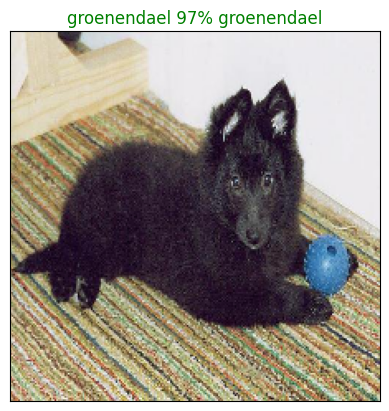

In [61]:
plot_pred(prediction_probabilities=predictions,
          labels = val_labels,
          images = val_images,
          n=77)

# function to visualise model's top 10 predictions

* take an input of prediction probabilities array and a ground truth array and an integer
* find prediction using get_pred_label()
* fnd the top 10:
  - prediction probabilities indexes
  - prediction probabilities values
  - prediction labels
* plot the 10 prediction probability values and labels, coloring the true label green

In [64]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  pred_prob, true_label = prediction_probabilities[n], labels[n]
  # get the predicted label:
  pred_label = get_pred_label(pred_prob)
  # find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # find top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation="vertical")

  #change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

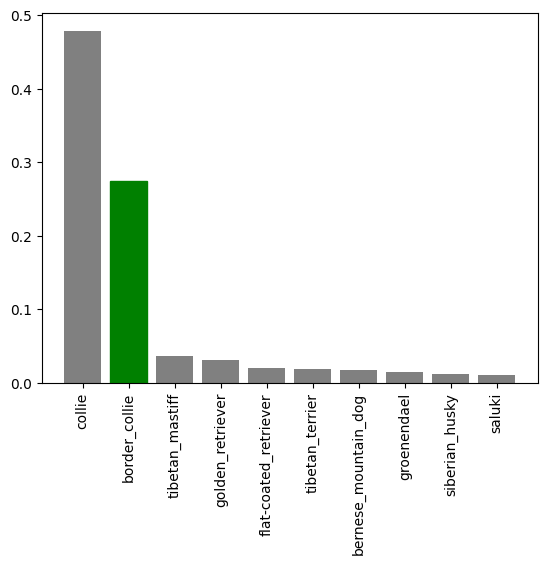

In [65]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

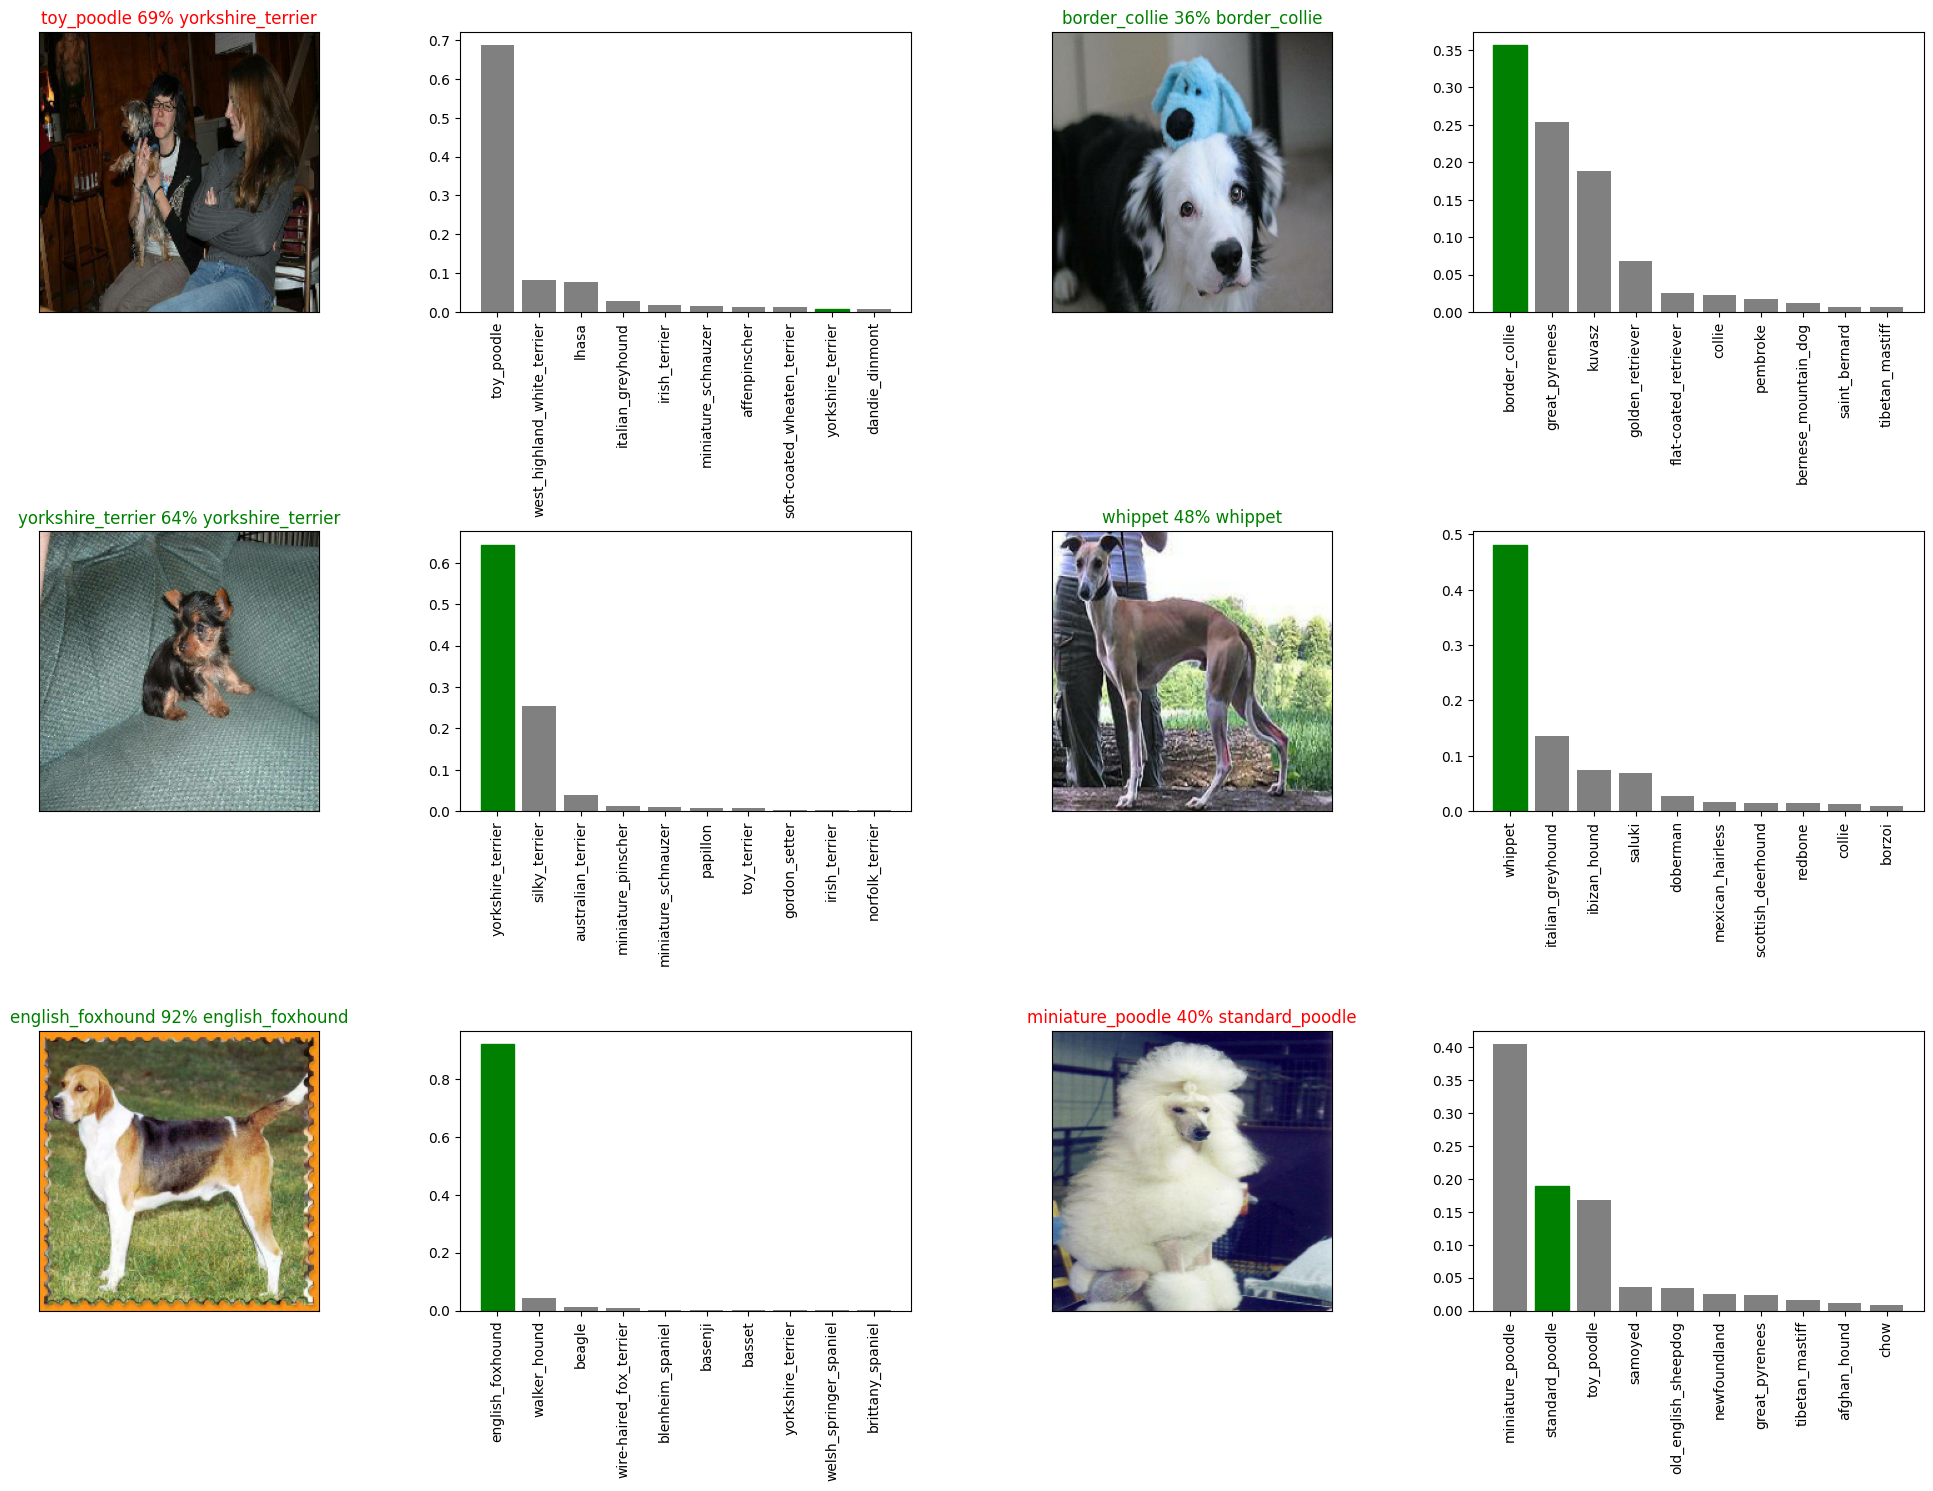

In [67]:
# Let's check a few predictions and their different values
i_multiplier =10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# saving and loading a trained model



In [68]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("/content/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [69]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [70]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

Saving model to: /content/Dog Vision/models/20231105-09591699178359-1000-images-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/Dog Vision/models/20231105-09591699178359-1000-images-Adam.h5'

In [71]:
# Load our model trained on 1000 images
model_1000_images = load_model("/content/Dog Vision/models/20231105-09591699178359-1000-images-Adam.h5")

Loading saved model from: /content/Dog Vision/models/20231105-09591699178359-1000-images-Adam.h5


In [72]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 0s 49ms/step - loss: 1.1683 - accuracy: 0.7050


[1.1683233976364136, 0.7049999833106995]

In [73]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

7/7 [==============================] - 1s 51ms/step - loss: 1.1683 - accuracy: 0.7050


[1.1683233976364136, 0.7049999833106995]

# training a model on the full dataset

In [74]:
#size of the full dataset
len(X), len(y)

(10222, 10222)

In [75]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


In [76]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Byuilding a model with: https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4


In [77]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [78]:
%tensorboard --logdir /content/Dog\ Vision/logs

Reusing TensorBoard on port 6006 (pid 1341), started 0:47:35 ago. (Use '!kill 1341' to kill it.)

<IPython.core.display.Javascript object>

In [79]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 23s 58ms/step - loss: 1.2925 - accuracy: 0.6779
Epoch 2/100
320/320 [==============================] - 18s 57ms/step - loss: 0.3779 - accuracy: 0.8859
Epoch 3/100
320/320 [==============================] - 18s 57ms/step - loss: 0.2190 - accuracy: 0.9404
Epoch 4/100
320/320 [==============================] - 18s 57ms/step - loss: 0.1423 - accuracy: 0.9648
Epoch 5/100
320/320 [==============================] - 19s 59ms/step - loss: 0.0989 - accuracy: 0.9789
Epoch 6/100
320/320 [==============================] - 19s 60ms/step - loss: 0.0687 - accuracy: 0.9898
Epoch 7/100
320/320 [==============================] - 18s 56ms/step - loss: 0.0526 - accuracy: 0.9934
Epoch 8/100
320/320 [==============================] - 18s 56ms/step - loss: 0.0414 - accuracy: 0.9952
Epoch 9/100
320/320 [==============================] - 18s 56ms/step - loss: 0.0334 - accuracy: 0.9969
Epoch 10/100
320/320 [==============================] - 18s 56ms/step - l

In [80]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

Saving model to: /content/Dog Vision/models/20231105-10121699179147-all-images-Adam.h5...


'/content/Dog Vision/models/20231105-10121699179147-all-images-Adam.h5'

In [81]:
# Load in the full model
loaded_full_model = load_model("/content/Dog Vision/models/20231105-10121699179147-all-images-Adam.h5")

Loading saved model from: /content/Dog Vision/models/20231105-10121699179147-all-images-Adam.h5


# making predictions on test dataset

In [90]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "/content/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['/content/Dog Vision/test/740599f0dc24bf74c8bab1c20305dcc2.jpg',
 '/content/Dog Vision/test/4c19bb5a59fc1dce9981e18818987593.jpg',
 '/content/Dog Vision/test/de3fbd6fb5444fcf14390ac90545c2f1.jpg',
 '/content/Dog Vision/test/dea92807aa2ac37bbc2dabf1b0eb6a39.jpg',
 '/content/Dog Vision/test/8646d62c1e40c6a1806b472508200b89.jpg',
 '/content/Dog Vision/test/d6bc129ff291bedc5ccdb11152b22f85.jpg',
 '/content/Dog Vision/test/240466d7cb9501fca06b5cc153f2ba88.jpg',
 '/content/Dog Vision/test/06be2fe757a1daa5fbcb51fdf2f5c613.jpg',
 '/content/Dog Vision/test/4627fcbeb62a98c90759cdc089b27043.jpg',
 '/content/Dog Vision/test/6511d43848106e99330879ac2a836cd9.jpg']

In [91]:
# How many test images are there?
len(test_filenames)

10357

In [92]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [93]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [94]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 23s 70ms/step


In [95]:
# Check out the test predictions
test_predictions[:10]

array([[1.09291826e-10, 2.76108068e-07, 4.56555821e-10, ...,
        3.52803090e-06, 6.44987563e-10, 7.41732176e-10],
       [3.31818687e-12, 4.07136862e-13, 4.32489287e-12, ...,
        8.73171368e-15, 6.50272547e-14, 2.89731108e-12],
       [1.69086878e-08, 3.27386438e-08, 7.96298938e-09, ...,
        6.52845670e-03, 9.25533300e-07, 6.84950919e-06],
       ...,
       [2.42116882e-10, 1.35920287e-13, 2.71347658e-12, ...,
        3.66606268e-13, 2.97775449e-13, 5.01913511e-11],
       [1.22810884e-09, 1.05862119e-09, 1.77779892e-11, ...,
        9.62801927e-09, 1.39047067e-08, 3.99162969e-09],
       [6.31337782e-09, 1.97924765e-09, 8.81610673e-10, ...,
        5.12946130e-09, 8.29792413e-09, 2.72381267e-11]], dtype=float32)

Preparing test dataset predictions for Kaggle

In [96]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [99]:
# Append test image ID's to predictions DataFrame
test_path = "/content/Dog Vision/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,740599f0dc24bf74c8bab1c20305dcc2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4c19bb5a59fc1dce9981e18818987593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,de3fbd6fb5444fcf14390ac90545c2f1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dea92807aa2ac37bbc2dabf1b0eb6a39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8646d62c1e40c6a1806b472508200b89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,740599f0dc24bf74c8bab1c20305dcc2,1.092918e-10,2.761081e-07,4.565558e-10,8.793947e-11,1.186592e-10,1.310615e-05,2.608636e-10,3.546355e-10,1.660179e-10,...,3.097399e-11,6.828919e-11,7.171768e-12,1.789559e-07,6.276347e-07,4.323596e-11,1.616883e-11,3.528031e-06,6.449876e-10,7.417322e-10
1,4c19bb5a59fc1dce9981e18818987593,3.318187e-12,4.071369e-13,4.324893e-12,6.238503e-14,9.219602e-16,1.243306e-14,7.721099e-11,4.886886e-15,2.660059e-14,...,9.955967e-11,2.171332e-15,1.256825e-13,2.535398e-16,6.618664e-13,8.265904e-14,2.536032e-12,8.731714e-15,6.502725e-14,2.897311e-12
2,de3fbd6fb5444fcf14390ac90545c2f1,1.690869e-08,3.273864e-08,7.962989e-09,3.529724e-08,9.683934e-01,3.408633e-08,4.273724e-10,6.601003e-07,3.783764e-09,...,1.214591e-08,1.273211e-06,8.162709e-11,8.418550e-06,1.023227e-08,5.673353e-10,8.098909e-07,6.528457e-03,9.255333e-07,6.849509e-06
3,dea92807aa2ac37bbc2dabf1b0eb6a39,1.047952e-09,2.148619e-08,1.275726e-10,2.521589e-09,1.507167e-12,5.568129e-09,1.028817e-08,6.795048e-12,3.109398e-12,...,1.309486e-09,7.152482e-13,7.090506e-12,1.796617e-10,7.197592e-12,8.160796e-12,8.199731e-14,3.590200e-10,1.179996e-13,2.327433e-12
4,8646d62c1e40c6a1806b472508200b89,1.147208e-13,3.836163e-10,4.453886e-12,5.298442e-11,9.275681e-13,7.515961e-13,3.695718e-13,2.563058e-12,3.451663e-15,...,3.298007e-11,6.219326e-13,2.417840e-11,4.001973e-13,3.011085e-13,8.740892e-14,1.191713e-14,2.101522e-14,3.347728e-14,2.463474e-14


In [101]:
preds_df.to_csv("/content/Dog Vision/full_submission_1_mobilienetV2_adam.csv",
                 index=False)

#Making predictions on custom images

In [102]:
# Get custom image filepaths
custom_path = "/content/Dog Vision/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [103]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [104]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 1s/step


In [105]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['great_pyrenees', 'golden_retriever', 'clumber']

In [106]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

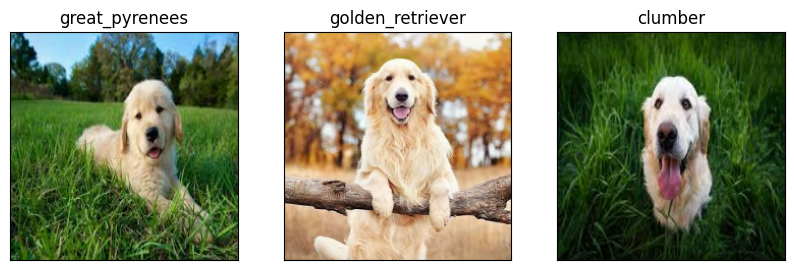

In [107]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)